In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Introduction to the Keras Functional API

- Sequential API : one imput, one output, one 'path' within the network !

With the **Functional API** :
- multiple inputs
- multiple outputs
- multiple pathes within the network ('Network in Network', 'Residual Block', 'Inception block')
- useful when reusing pre-trained networks

### Application : image classification with MNIST 

In [2]:
# some datasets are available directly with Keras
from keras.datasets.mnist import load_data

# train/val/test
from sklearn.model_selection import train_test_split

x_train : (48000, 28, 28) | uint8
y_train : (48000,) | uint8
x_val : (12000, 28, 28) | uint8
y_val : (12000,) | uint8
x_test : (10000, 28, 28) | uint8
y_test : (10000,) | uint8


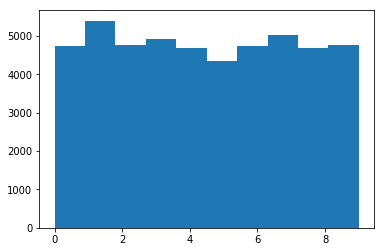

In [5]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=True, stratify=y_train, test_size=0.2)

print("x_train : {} | {}".format(x_train.shape, x_train.dtype))
print("y_train : {} | {}".format(y_train.shape, y_train.dtype))
print("x_val : {} | {}".format(x_val.shape, x_val.dtype))
print("y_val : {} | {}".format(y_val.shape, y_val.dtype))
print("x_test : {} | {}".format(x_test.shape, x_test.dtype))
print("y_test : {} | {}".format(y_test.shape, y_test.dtype))
_ = plt.hist(y_train, bins=10)

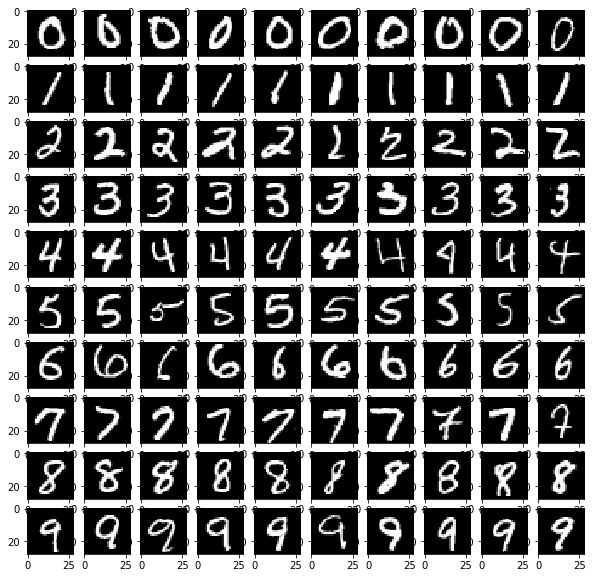

In [12]:
fig = plt.figure(figsize=(10, 10))
for id_class in range(10):
    indices = np.where(y_train==id_class)[0]
    for i in range(10):
        plt.subplot(10, 10, id_class*10 + i + 1)
        plt.imshow(x_train[indices[i]], cmap='gray')
plt.show()

In [19]:
# minimal pre-processsing 
# add new 'dim' : channel dimension 
x_train = np.expand_dims(x_train, axis=-1).astype(np.float32) / 255.
x_val = np.expand_dims(x_val, axis=-1).astype(np.float32) / 255.
x_test = np.expand_dims(x_test, axis=-1).astype(np.float32) / 255.

In [20]:
# one hot encoding for the labels
from keras.utils import to_categorical

In [21]:
y_train = to_categorical(y_train,num_classes=10)
y_val = to_categorical(y_val,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

In [22]:
print("x_train : {} | {}".format(x_train.shape, x_train.dtype))
print("y_train : {} | {}".format(y_train.shape, y_train.dtype))
print("x_val : {} | {}".format(x_val.shape, x_val.dtype))
print("y_val : {} | {}".format(y_val.shape, y_val.dtype))
print("x_test : {} | {}".format(x_test.shape, x_test.dtype))
print("y_test : {} | {}".format(y_test.shape, y_test.dtype))

x_train : (48000, 28, 28, 1) | float32
y_train : (48000, 10) | float64
x_val : (12000, 28, 28, 1) | float32
y_val : (12000, 10) | float64
x_test : (10000, 28, 28, 1) | float32
y_test : (10000, 10) | float64


### Build a model with the Functional API

In [63]:
# tool box

# some layers : 
from keras.layers import Input 
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization
from keras.layers import Activation, LeakyReLU
from keras.layers import MaxPool2D, AveragePooling2D, Flatten, GlobalAveragePooling2D
from keras.layers import Add, Concatenate

# here : the functional API 
from keras.models import Model

# some optimzers
from keras.optimizers import Adam, SGD, RMSprop

# some keras callbacks to monitor the training
from keras.callbacks import Callback,EarlyStopping, ReduceLROnPlateau

In [74]:
# need to add a 'fake' dimension for the 'gray' channel
input_layer = Input(shape=(28,28,1))

In [75]:
# 28x28 feature maps
x = Conv2D(filters=8, kernel_size=3, padding='same', strides=1, use_bias=False)(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=16, kernel_size=3, padding='same', strides=2, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 14x14 features maps
x = Conv2D(filters=16, kernel_size=3, padding='same', strides=1, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', strides=2, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 7x7 feature maps
x = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', strides=2, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
output_layer = Dense(10, activation='softmax')(x)

In [76]:
output_layer

<tf.Tensor 'dense_6/Softmax:0' shape=(?, 10) dtype=float32>

In [77]:
model = Model(inputs=input_layer, outputs=output_layer)
# we can use 'model' as a classical Sequential) model (.fit(), .predict(), .evaluate() ) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 8)         72        
_________________________________________________________________
batch_normalization_34 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_34 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 16)        1152      
_________________________________________________________________
batch_normalization_35 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
activation_35 (Activation)   (None, 14, 14, 16)        0         
__________

## Launch the training

In [78]:
sgd = SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

In [79]:
print(ReduceLROnPlateau.__doc__)

Reduce learning rate when a metric has stopped improving.

    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This callback monitors a
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.

    # Example
        ```python
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=5, min_lr=0.001)
        model.fit(X_train, Y_train, callbacks=[reduce_lr])
        ```

    # Arguments
        monitor: quantity to be monitored.
        factor: factor by which the learning rate will
            be reduced. new_lr = lr * factor
        patience: number of epochs with no improvement
            after which learning rate will be reduced.
        verbose: int. 0: quiet, 1: update messages.
        mode: one of {auto, min, max}. In `min` mode,
            lr will be reduced when the quantity
            monitored has stopped d

In [80]:
# add some callbacks

early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, min_delta=0.)

redure_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=1e-5, patience=1, verbose=1, factor=0.1)

In [81]:
callbacks = [early_stop, redure_lr]

In [82]:
epochs = 100
batch_size = 64
verbose = 1 # do not set to 1 !! (issue with progbar with remore notebooks)

In [83]:
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    shuffle=True,
                    verbose=verbose)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 84s - loss: 0.1711 - acc: 0.9478 - val_loss: 0.0717 - val_acc: 0.9785
Epoch 2/100
48000/48000 [==============================] - 77s - loss: 0.0499 - acc: 0.9845 - val_loss: 0.0754 - val_acc: 0.9758
Epoch 3/100
48000/48000 [==============================] - 78s - loss: 0.0354 - acc: 0.9892 - val_loss: 0.0619 - val_acc: 0.9801
Epoch 4/100
48000/48000 [==============================] - 77s - loss: 0.0277 - acc: 0.9914 - val_loss: 0.1011 - val_acc: 0.9688
Epoch 5/100
48000/48000 [==============================] - 79s - loss: 0.0224 - acc: 0.9927 - val_loss: 0.0420 - val_acc: 0.9868
Epoch 6/100
48000/48000 [==============================] - 78s - loss: 0.0177 - acc: 0.9944 - val_loss: 0.0523 - val_acc: 0.9848
Epoch 7/100
47936/48000 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9950
Epoch 00006: reducing learning rate to 0.010000000149011612.
48000/48000 [======

In [88]:
# plot history 
history.history.keys()

dict_keys(['loss', 'lr', 'val_loss', 'val_acc', 'acc'])

Text(0,0.5,'learning_rate')

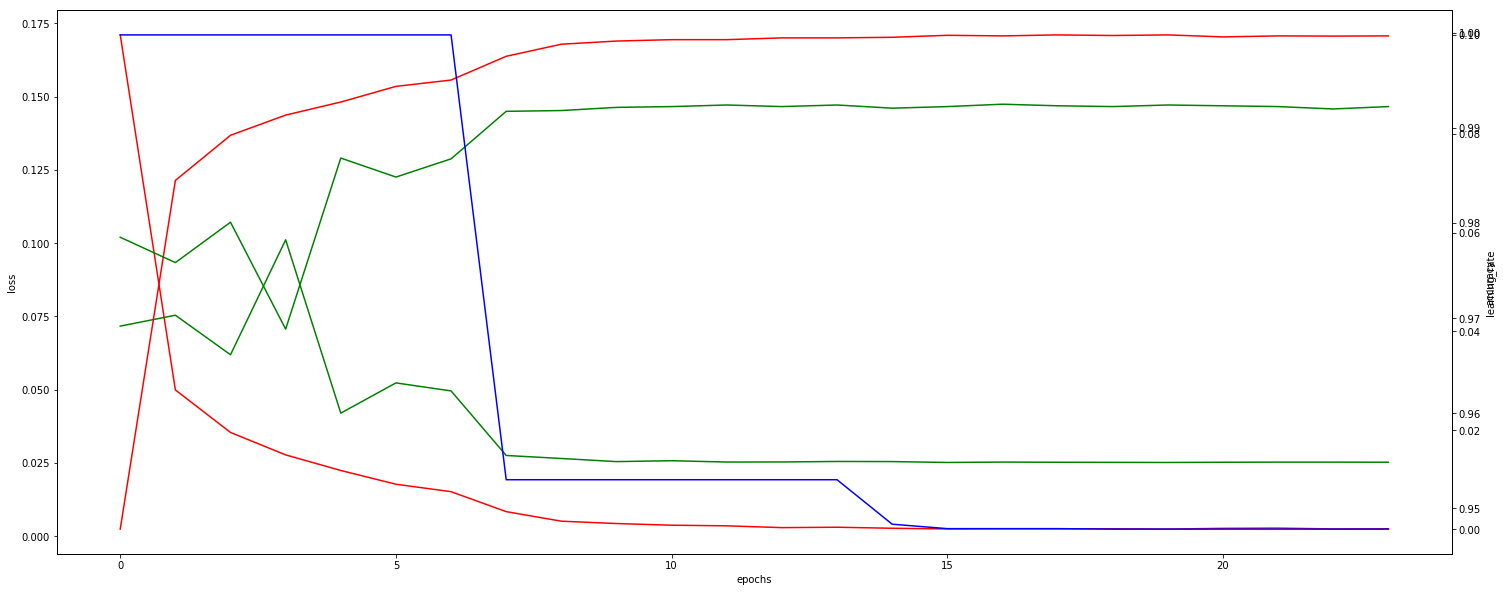

In [97]:
# plt.figure(figsize=(25,10))
fig, ax_loss = plt.subplots(figsize=(25,10))

ax_acc = ax_loss.twinx()
ax_lr = ax_loss.twinx()

ax_loss.plot(history.history['loss'], 'r')
ax_loss.plot(history.history['val_loss'], 'g')
ax_loss.set_xlabel('epochs')
ax_loss.set_ylabel('loss')

ax_acc.plot(history.history['acc'], 'r')
ax_acc.plot(history.history['val_acc'], 'g')
ax_acc.set_ylabel('accuracy')

ax_lr.plot(history.history['lr'], 'b')
ax_lr.set_ylabel('learning_rate')

In [73]:
print(model.evaluate(x_train, y_train, verbose=0))
print(model.evaluate(x_val, y_val, verbose=0))
print(model.evaluate(x_test, y_test, verbose=0))

[0.0021505576197553941, 0.99964583333333334]
[0.025172021473782176, 0.99333333333333329]
[0.02206231994029513, 0.99219999999999997]
